# Vehicle Tracking with SVM and HOG Feature Extraction

In [1]:
import matplotlib
import os 
import shutil
import progressbar 
import sklearn
import cv2
import numpy as np 
import math
from skimage.feature import hog
from scipy import misc
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip

if int(sklearn.__version__.replace('.', '')) >= 180: 
    from sklearn.model_selection import train_test_split as tts
    from sklearn.model_selection import cross_val_score as cvs
else:
    from sklearn.cross_validation import train_test_split as tts 
    from sklearn.cross_validation import cross_val_score as cvs
    
    
%run util.py

%matplotlib inline

DATA_DIR = "./data"

## Data 
The data is somewhat oddly organized. We wish to merge all available data into a single compendium, and then split it into training, validation, and testing sets. 

First, the data is re-organized so that it may be more easily accessed. All the images are placed into one folder, and given a unique identifier. We have 17760 images. 

In [2]:
if not (os.path.isdir(DATA_DIR)): 
    os.mkdir(DATA_DIR)

    
full_data = []
image_number = 0
   
for root, dirs, files in os.walk('./vehicles'):
    print("Processing " + root)   
    files_proc = [f for f in files if '.png' in f]          
    
    for file in files_proc:      
        orig_path = os.path.join(root, file)
        new_path = os.path.join(DATA_DIR, 'image' + str(image_number) + '.png')
           
        shutil.copyfile(orig_path, new_path)
            
        full_data.append((orig_path, new_path, 1))
            
        image_number += 1 
    
for root, dirs, files in os.walk('./non-vehicles'):   
    print("Processing " + root)
    files_proc = [f for f in files if '.png' in f]
                
    for file in files_proc: 
        orig_path = os.path.join(root, file)
        new_path = os.path.join(DATA_DIR, 'image' + str(image_number) + '.png')
            
        shutil.copyfile(orig_path, new_path)
            
        full_data.append((orig_path, new_path, 0))
                    
        image_number += 1
        
full_data = np.array(full_data).T           
print("Done - image files prepared.")


Processing ./vehicles
Processing ./vehicles/GTI_Far
Processing ./vehicles/GTI_Left
Processing ./vehicles/KITTI_extracted
Processing ./vehicles/GTI_MiddleClose
Processing ./vehicles/GTI_Right
Processing ./non-vehicles
Processing ./non-vehicles/GTI
Processing ./non-vehicles/Extras
Done - image files prepared.


(64, 64, 3)


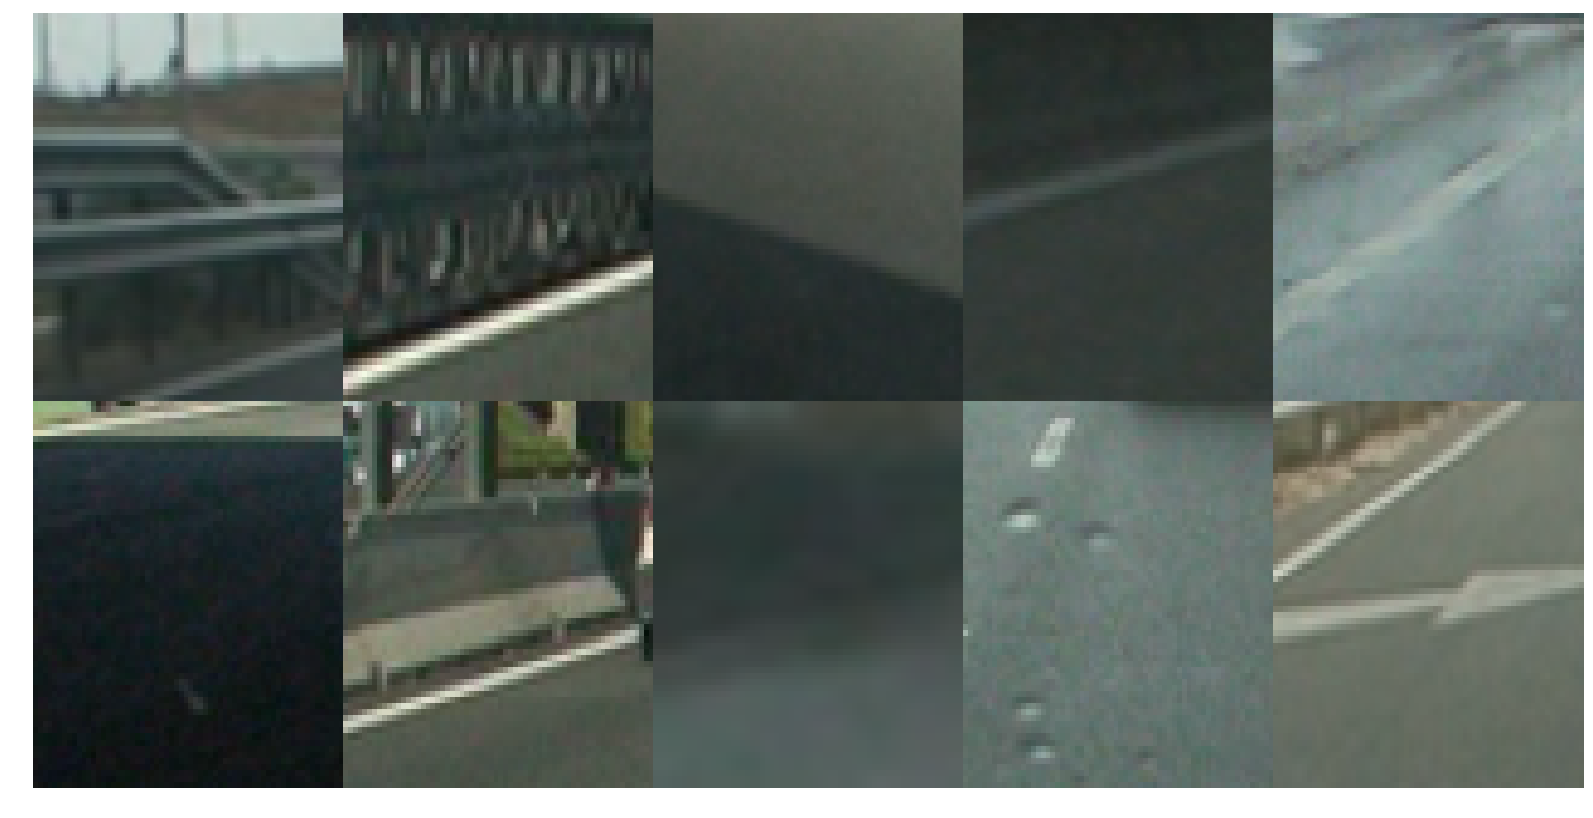

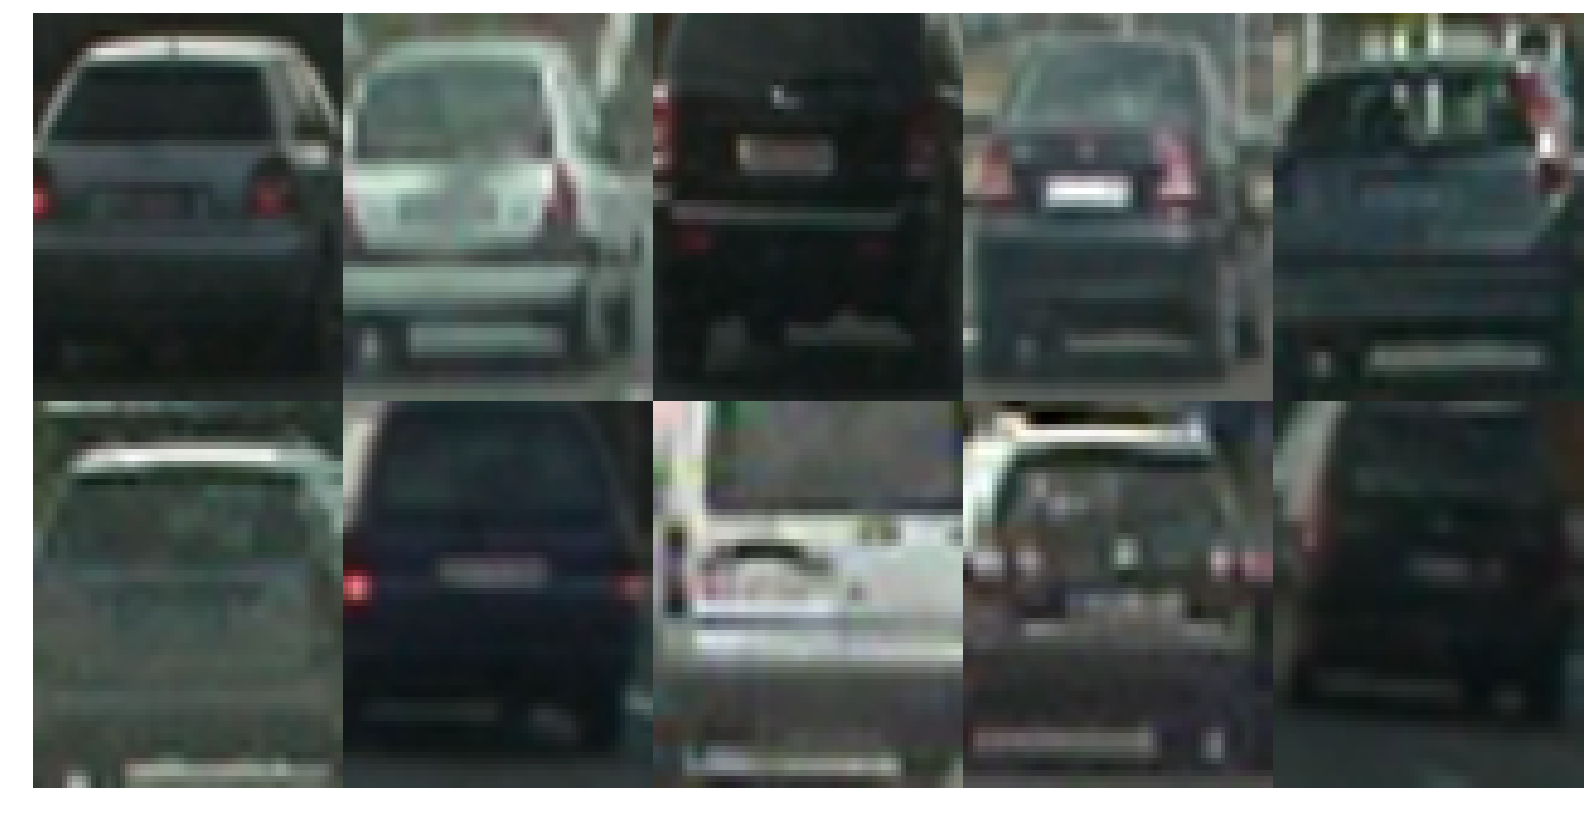

In [3]:
sample_nonvehicle = [image_path for i, image_path in enumerate(full_data[1]) if full_data[2][i] == '0'][0:10]
sample_nonvehicle_images = [misc.imread(image_path) for image_path in sample_nonvehicle]

figure1_top = mosaic(sample_nonvehicle_images, 10, 20, 5)
figure1_top.show()

sample_vehicle = [image_path for i, image_path in enumerate(full_data[1]) if full_data[2][i] == '1'][0:10]
sample_vehicle_images = [misc.imread(image_path) for image_path in sample_vehicle]

figure1_bottom = mosaic(sample_vehicle_images, 10, 20, 5)
figure1_bottom.show()

print(sample_vehicle_images[0].shape)

**Figure 1** Sample images. As is obvious, the top panel contains images wihtout vehicles, and the bottom panel contains images of vehicles. 

## Image Pre-processing

At this point the pre-processing techniques applied here may as well be considered 'traditional.' First, we apply histogram normalization (Contrast Limited Adapted Histogram Equalization, CLAHE) to each color input image, to mitigate the effects of diverse lighting, contrast, etc. in the input image. A light Gaussian filter is also applied, to minimize pixel noise. Finally, the images are converted the YUV color space. This choice is discussed further below. 

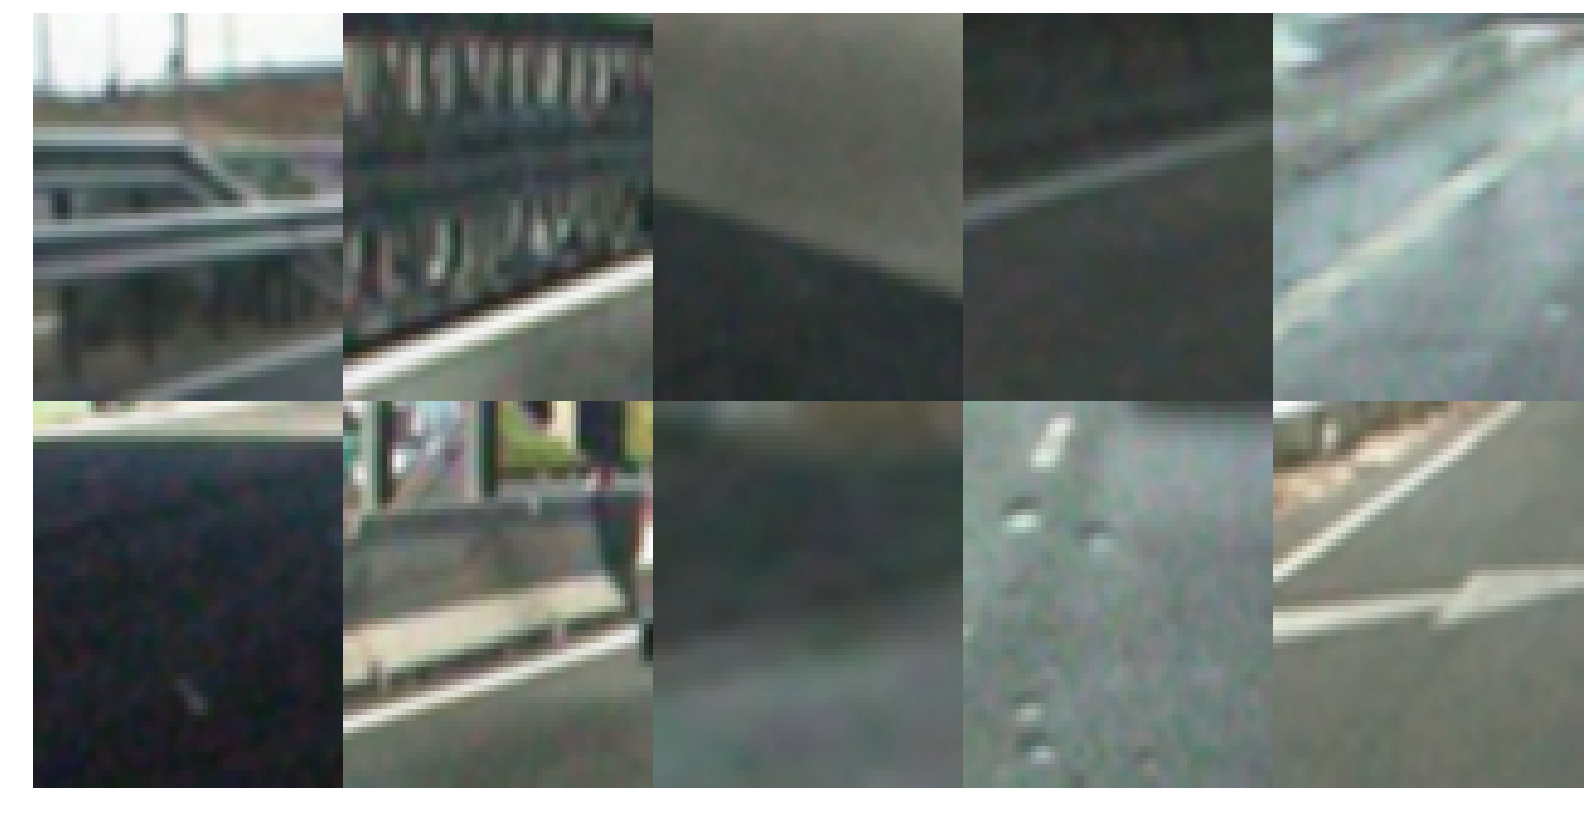

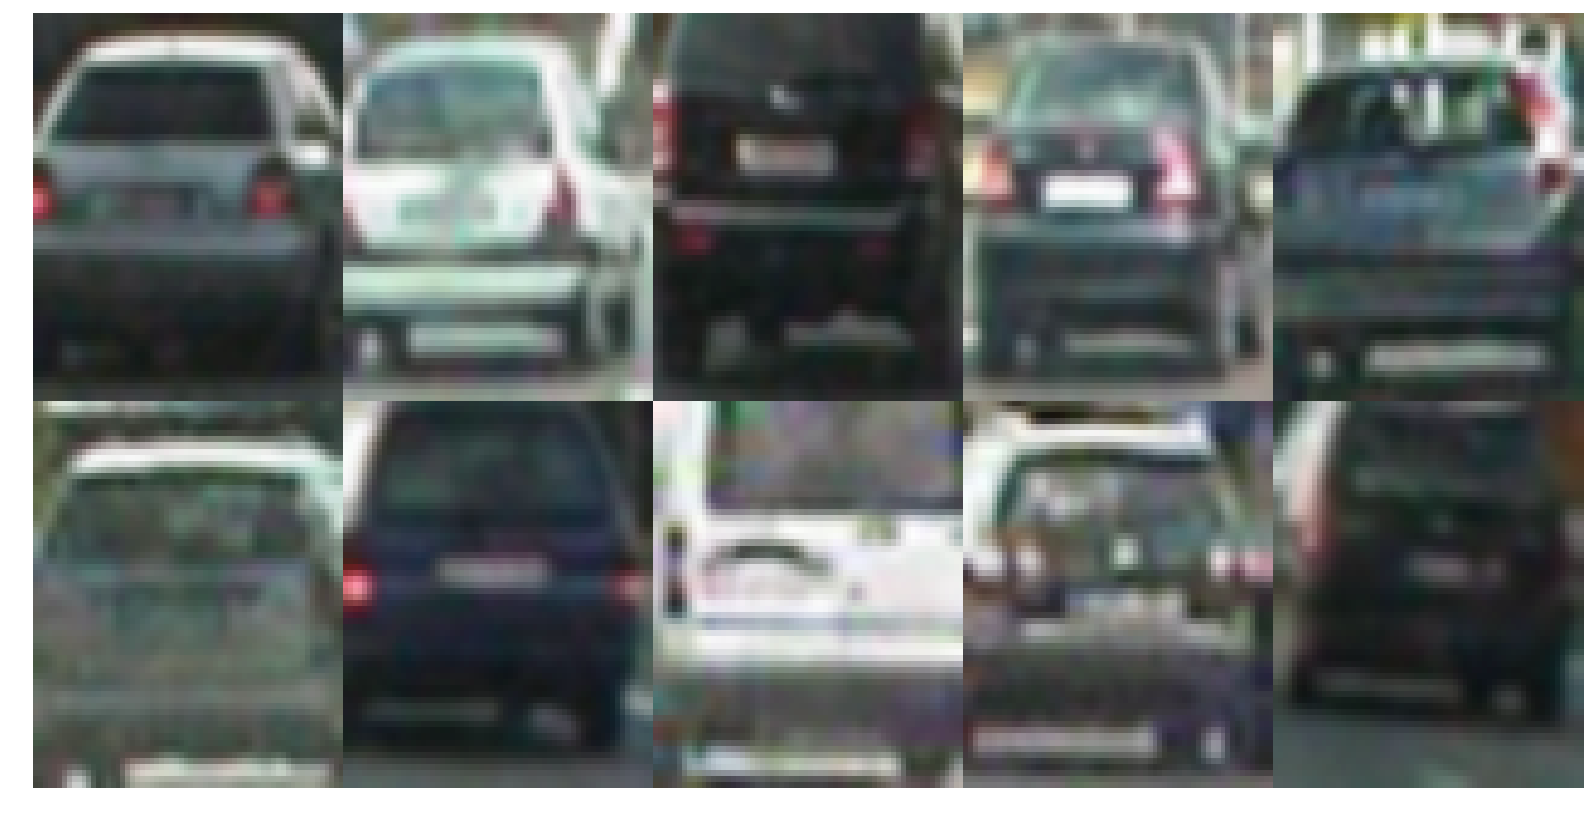

In [4]:
def image_preprocess(image, clahe_clipLimit=1, clahe_tileGridSize=(4,4), gaussian_ksize=(3,3)): 
    """ Encapsulate initial image pre-processing for tracking/detection pipeline. 
    
    This method encapsulates the initial pre-processing applied to each image in the pre-processing 
    pipeline. 
    
    Args: 
    image: Image to be pre-processed. 
    clahe_clipLimit: The clipLimit parameter for CLAHE.
    clahe_tileGridSize: The tileGridSize parameter for CLAHE.
    
    gaussian_ksize = Kernel size for the Gaussian filter. 
    Returns: 
    Pre-processed images (color, gray)
    """
    
    image_working = clahe_RGB(image, clipLimit=clahe_clipLimit, tileGridSize=clahe_tileGridSize)
    image_working = cv2.GaussianBlur(image_working, ksize=gaussian_ksize, sigmaX=0)
    image_working = cv2.cvtColor(image_working, cv2.COLOR_RGB2YUV)
    
    return image_working 

sample_nonvehicle_preproc = [image_preprocess(image) for image in sample_nonvehicle_images]
figure_2_top = mosaic([cv2.cvtColor(col, cv2.COLOR_YUV2RGB) for col in sample_nonvehicle_preproc], 10, 20, 5).show()

sample_vehicle_preproc = [image_preprocess(image) for image in sample_vehicle_images]
figure2_bottom = mosaic([cv2.cvtColor(col, cv2.COLOR_YUV2RGB) for col in sample_vehicle_preproc], 10, 20, 5).show()

** Figure 2 ** The panel ordering and contents is analogous to figure 1, save for the extra image pre-processing. Note the more uniform image luminance and contrast. 

## Feature Extraction 

Each pre-processed image has, at this point, been transformed to YUV space. HOG features are extracted from each channel of the YUV image. This color space has the advantage of encoding information in a way more closely related to human visual perception than the RGB space, which has advantages for  (Podpora et. al., 2014). 

To each channel of the YUV image, a HOG feature extractor is applied with an orientation of 9, 8 pixels per cell, and 2 cells per block. Given that the input images are 64 x 64, these parameters, as those in the corresponding Udacity lessons, after some experimentation, were found to best pick up salient edges in the image, without creating an impractically large feature space. 

Only HOG features were used here. Given the reasonable accuracy and size of the model in testing and validation (see below), the effect of adding more features based on color etc. would be negated by the corresponding increase in training time. Below, HOG features for the Y channel are visualized. 

In [5]:
def extract_features(image, hog_ppc=8, hog_orientation=9, hog_cpb=2, vector=True, concat=True, Y_only=True): 
    """ Extract HOG and color features, concatenate and normalize.
        
    Args: 
    image: Input image (Must be YUV).
    hog_ppc: Pixels per cell, for HOG feature extraction. 
    hog_orientation: Orientation for HOG feature extraction. 
    hog_cpb: Cells per block, for HOG feature extraction. 
    vector: Should a feature vector be computed? 
    concat: Should the resulting feature vectors be concatenated together? 
    
    Returns: 
    Feature vector with color features and hog features, concatenated. 
    """
   
    Y, U, V = image[:,:,0], image[:,:,1], image[:,:,2]
    
    get_features = lambda channel: hog(channel, 
                                        orientations=hog_orientation, 
                                        pixels_per_cell=(hog_ppc, hog_ppc),
                                        cells_per_block=(hog_cpb, hog_cpb), 
                                        transform_sqrt=False, 
                                        visualise=False, 
                                        feature_vector=vector)
    hog_features_Y = get_features(Y)
    hog_features_U = get_features(U)
    hog_features_V = get_features(V)
    
    if concat and not Y_only: 
        ret_features = np.concatenate((hog_features_Y, hog_features_U, hog_features_V))
    elif Y_only: 
        ret_features = hog_features_Y
    else:
        ret_features = (hog_features_Y, hog_features_U, hog_features_V)
    
    return ret_features  

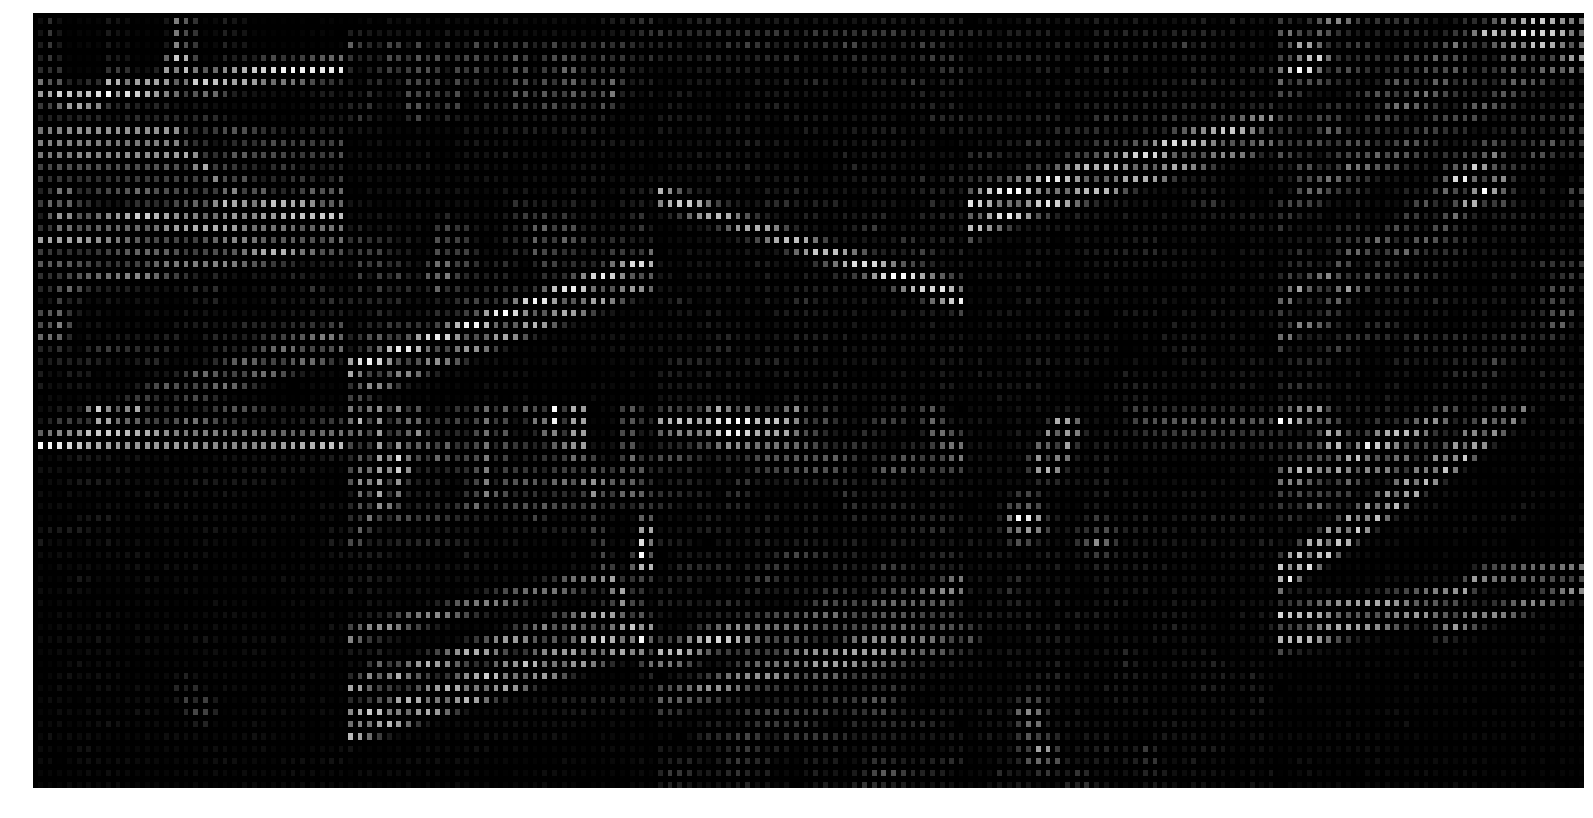

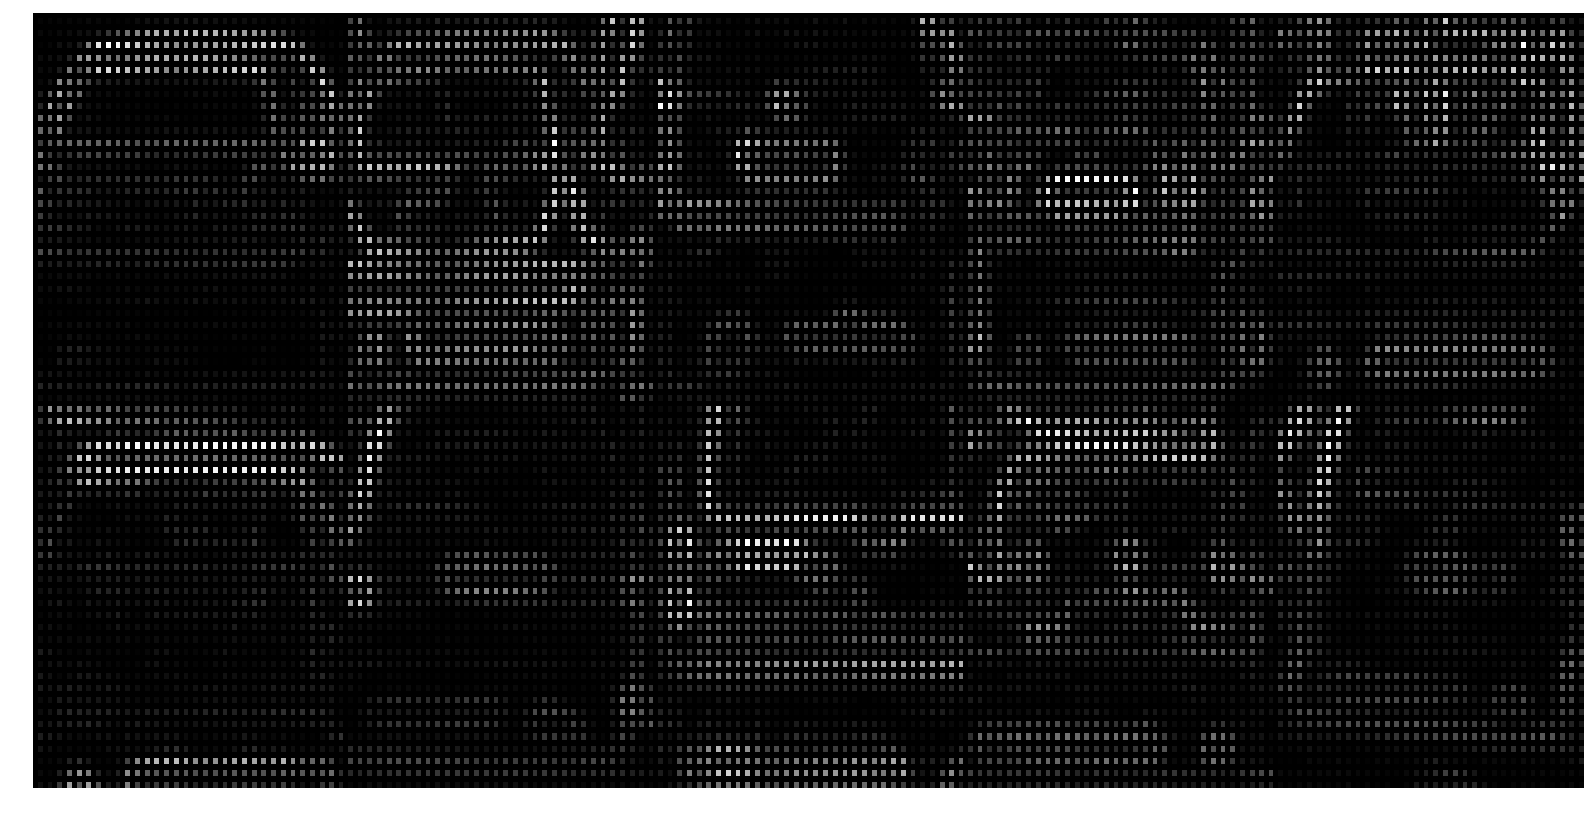

In [6]:
## Simple visualization of HOG on the sample images.
apply_hog = lambda img: hog(img, 9, (2,2), (8,8), True, False)

sample_nonvehicle_Y   = [image[:,:,0] for image in sample_nonvehicle_preproc]
sample_nonvehicle_hog = [apply_hog(image)[1] for image in sample_nonvehicle_Y]
figure_2_top = mosaic(sample_nonvehicle_hog, 10, 20, 5, cmap='gray').show()

sample_vehicle_Y   = [image[:,:,0] for image in sample_vehicle_preproc]
sample_vehicle_hog = [apply_hog(image)[1] for image in sample_vehicle_Y]
figure2_bottom = mosaic(sample_vehicle_hog, 10, 20, 5, cmap='gray').show()

**Figure 3** An example of HOG featuresets. Panel order is as above. 

## Classifier 

### Dataset Preparation 

The data is shuffled split as follows: 
- 70% Training (30% validation)
- 30% Testing 

and feature vectors are prepared for all images. Features are only normalized based on the training set. 

In [7]:
X_all, y_all = sklearn.utils.shuffle(full_data[1], full_data[2])
print("Loading images.")
X_all = [misc.imread(image_path) for image_path in X_all]

Loading images.


In [8]:
print("Preprocessing.")
X_all = [image_preprocess(image) for image in X_all]

Preprocessing.


In [9]:
print("Preparing features.")
X_all = [extract_features(image, Y_only=False) for image in X_all]

Preparing features.


In [10]:
print("Preparing dataset split.")
X_training, X_testing, y_training, y_testing = tts(X_all, 
                                                   y_all, 
                                                   test_size=0.3)
_, X_validation, _, y_validation = tts(X_training, 
                                       y_training, 
                                       test_size=0.3)

print("Normalizing.")
feature_scaler = sklearn.preprocessing.RobustScaler().fit(X_training)

X_training = feature_scaler.transform(np.vstack(X_training).astype(np.float64))
X_validation = feature_scaler.transform(np.vstack(X_validation).astype(np.float64))
X_testing = feature_scaler.transform(np.vstack(X_testing).astype(np.float64))

Preparing dataset split.
Normalizing.


### Training 

After a number of experiments, a support vector machine with a linear kernel was found to perform best. The sklearn implementation 'LinearSVC' is used here.

To perform a preliminary assessment of the efficacy of the model, 5-fold cross validation is applied with the validation set. The observed cross validation accuracy clearly supports the selected model as a valid choice. 

In [11]:
from sklearn.svm import SVC

model = SVC(kernel='linear', C=1, random_state=1729)

In [12]:
print("Cross Validation.")
cv_5fold = cvs(model, X_validation, y_validation, cv=5)

print(cv_5fold)

Cross Validation.
[ 0.98793566  0.98123324  0.97050938  0.98525469  0.96782842]


In [13]:
## The model is trained, and its performance evaluated. 
print("Fitting model.")
model.fit(X_training, y_training)

print("Testing.")
model.score(X_testing, y_testing)

Fitting model.
Testing.


0.98385885885885882

## Vehicle Idenfitication 

Now that a suitably performant model has been prepared, we move on to the definition of a pipieline for vehicle detection in individual images/video frames. 

The pipeline is presented in the source block below, encapsulated in the `detect_vehicles` method of the `VehicleDetector` class. 

1. Images are copied, and an output version is kept for annotation of detected vehicles. 
2. The working copy of the image is pre-processed, using the pipeline defined above. 
3. The wokring copy is cropped, and only the region where vehicles could potentially be detected is considered in the steps that follow. 
4. If applicable, the working copy is scaled, to allow a search with larger windows. 
5. HOG features are computed from the result of step *4*, for all three color channels (Y, U, V).
6. All window boundaries are computed in advance. 
7. HOG (oink) features for each window are extracted, and those for each color channel are concatenated. 
8. The features are fed to the pre-trained classifier.
9. If a vehicle is detected, a global heatmap is updated with the addition of 1 in each cell corresponding to pixels where a vehicle was detected. 
10. Steps **[4 - 9]** are repeated for all window scales. 
11. The heatmap is restricted based on a minimum threshold of overlapping windows. 
12. Islands of nonzero values in the heatmap are extracted from the heatmap. 
13. Bounding boxes are drawn onto the output copy of the original input image 
14. The output image is returned. 

The implementation presented here only computes HOG features once for each scale and input image, to avoid the computationl burden (and repetition) of computing HOG features de-novo for each sliding window. The model supports multiple window scales, but for the sake of exposition and brevity, only 1.5 scaling is used when images and video are processed below. 

To control for possible false positives, only candidate 'vehicles' where at least two windows report a positive result are considered to be the genuine article. We makes use of a simple matrix representation of the image, where windows associated with a positive match are represented as islands of nonzero values. Computing a bounding box to identify these regions of overlap then becomes much simpler. 

Where the pipeline is applied to video, previous frames are taken into account to define high-confidence detections. A second heatmap defines the locations of vehicles in the previous frame of video. The heatmap defining the position of vehicles located in the current frame is added to that of the previous frame, and only those cells where there is sufficient evidence of a vehicle are considered. 

In [14]:
class VehicleDetector: 
    """ Encapsulate vehicle detection procedure and parameters. 
    
    Args: 
    model: The model to be used for prediction, must already be trained, obviously. 
    y0: Top y value of the window where cars are to be identified. 
    y1: Bottom y value of the window where cars are to be identified. 
    heat_threshold: Minimum number of overlapping windows for a detection to be considered valid. 
    scales: Image scales at which the analysis should be performed. Defaults are [1, 1.5]
    """
    def __init__(self, model, y0=350, y1=656, heat_threshold = 2, scales = [1.5], feature_scaler=feature_scaler, 
                video=False): 
        self.model = model
        self.y0 = y0
        self.y1 = y1
        self.heat_threshold = heat_threshold
        self.scales = scales
        self.feature_scaler = feature_scaler
        self.video = video
        self.previous_heat = None 
        
    def detect_vehicles(self, image): 
        """ Detect vehicles in a single frame of video, or a still image.
        
        Args: 
        image: Input image - not pre-processed, a raw frame of video or still image. 
        
        Returns: 
        3-Tuple (vehicle_locations, vehicle_boxes, output_image), the content is self-evident, 
        the output image will have bounding boxes around the identified vehicles. 
        """
        output_image = image
        cars_heat = np.zeros_like(output_image)
        
        image_working = image_preprocess(image)
        image_working = image_working[self.y0:self.y1, :, :]
        
        for scale in self.scales:
            if scale != 1: 
                image_working = cv2.resize(image_working, 
                                           (np.int(image_working.shape[1]/scale), 
                                            np.int(image_working.shape[0]/scale)))
        
            hog_ppc = 8
            hog_stride = 2
            window_width = 64
        
            features_Y, features_U, features_V = extract_features(image_working,
                                                                  hog_ppc=hog_ppc, 
                                                                  hog_orientation=9, 
                                                                  hog_cpb=2,
                                                                  vector=False,
                                                                  Y_only=False,
                                                                  concat=False)
        
            window_nsteps_y = image_working.shape[0]//(hog_ppc * hog_stride) 
            window_nsteps_x = (image_working.shape[1] - window_width)//(hog_ppc * hog_stride) 
              
            window_ys = range(0, image_working.shape[0] - window_width, image_working.shape[0]//window_nsteps_y)
            window_xs = range(0, image_working.shape[1] - window_width, (image_working.shape[1])//window_nsteps_x)
            
            ## For each window, we collect features, concatenate them apply the classifier, 
            ## and keep track of the window if it was predicted as containing a vehicle. 
            channel_features = lambda y, x, w, F: F[y:(y+w), x:(x+w)].ravel()
                                                                          
            feature_w = window_width//hog_ppc -1
            
            for window_y in window_ys: 
               
                feature_y = window_y//hog_ppc
                
                for window_x in window_xs: 
                
                    feature_x = window_x//hog_ppc
                    features_Y_this = channel_features(feature_y, feature_x, feature_w, features_Y)
                    features_U_this = channel_features(feature_y, feature_x, feature_w, features_U)
                    features_V_this = channel_features(feature_y, feature_x, feature_w, features_V)
                    
                    features = np.hstack((features_Y_this, features_U_this, features_V_this))
                    contains_car = self.model.predict(self.feature_scaler.transform(features.reshape(1,-1)))
                            
                    if contains_car == ['1']: 
                        window_y_out = np.int(window_y * scale)
                        window_x_out = np.int(window_x * scale)
                        window_w_out = np.int(window_width * scale)
                    
                        cars_heat[(window_y_out + self.y0):(window_y_out + self.y0 + window_w_out), window_x_out:(window_x_out + window_w_out)] += 1
                    
        ## Restrict heatmap based on threshold.
        cars_heat[cars_heat <= self.heat_threshold] = 0
        
        if self.video and self.previous_heat != None: 
            compound_heat = self.previous_heat + cars_heat 
            self.previous_heat = cars_heat 
            
            compound_heat[compound_heat <= 1] = 0
            cars = label(compound_heat)
        elif self.video and self.previous_heat == None:
            self.previous_heat = cars_heat
            cars = label(cars_heat)
        else: 
            cars = label(cars_heat)
        
        for car in range(1, cars[1]+1): 
            nz = (cars[0] == car).nonzero()
            nzx = np.array(nz[1])
            nzy = np.array(nz[0])
            
            box0 = (np.min(nzx), np.min(nzy))
            box1 = (np.max(nzx), np.max(nzy))
            
            cv2.rectangle(output_image, box0, box1, (0, 255, 255), 6)
            
            
        return output_image

In [15]:
test_images = []
for root, dirs, files in os.walk('./test_images'): 
    for file in files: 
        if '.jpg' in file: 
            test_images.append(misc.imread(os.path.join(root, file)))
test_images = np.array(test_images)
print("Loaded test images.")
print(test_images.shape)

detector = VehicleDetector(model)
test_images_detected = []
for i,image in enumerate(test_images): 
    print("Test image", i)
    image_detected = detector.detect_vehicles(image)
    misc.imsave(os.path.join('./output_images','test' + str(i) + '.jpg'), image_detected)
    test_images_detected.append(detector.detect_vehicles(image))
    

Loaded test images.
(6, 720, 1280, 3)
Test image 0
Test image 1
Test image 2
Test image 3
Test image 4
Test image 5


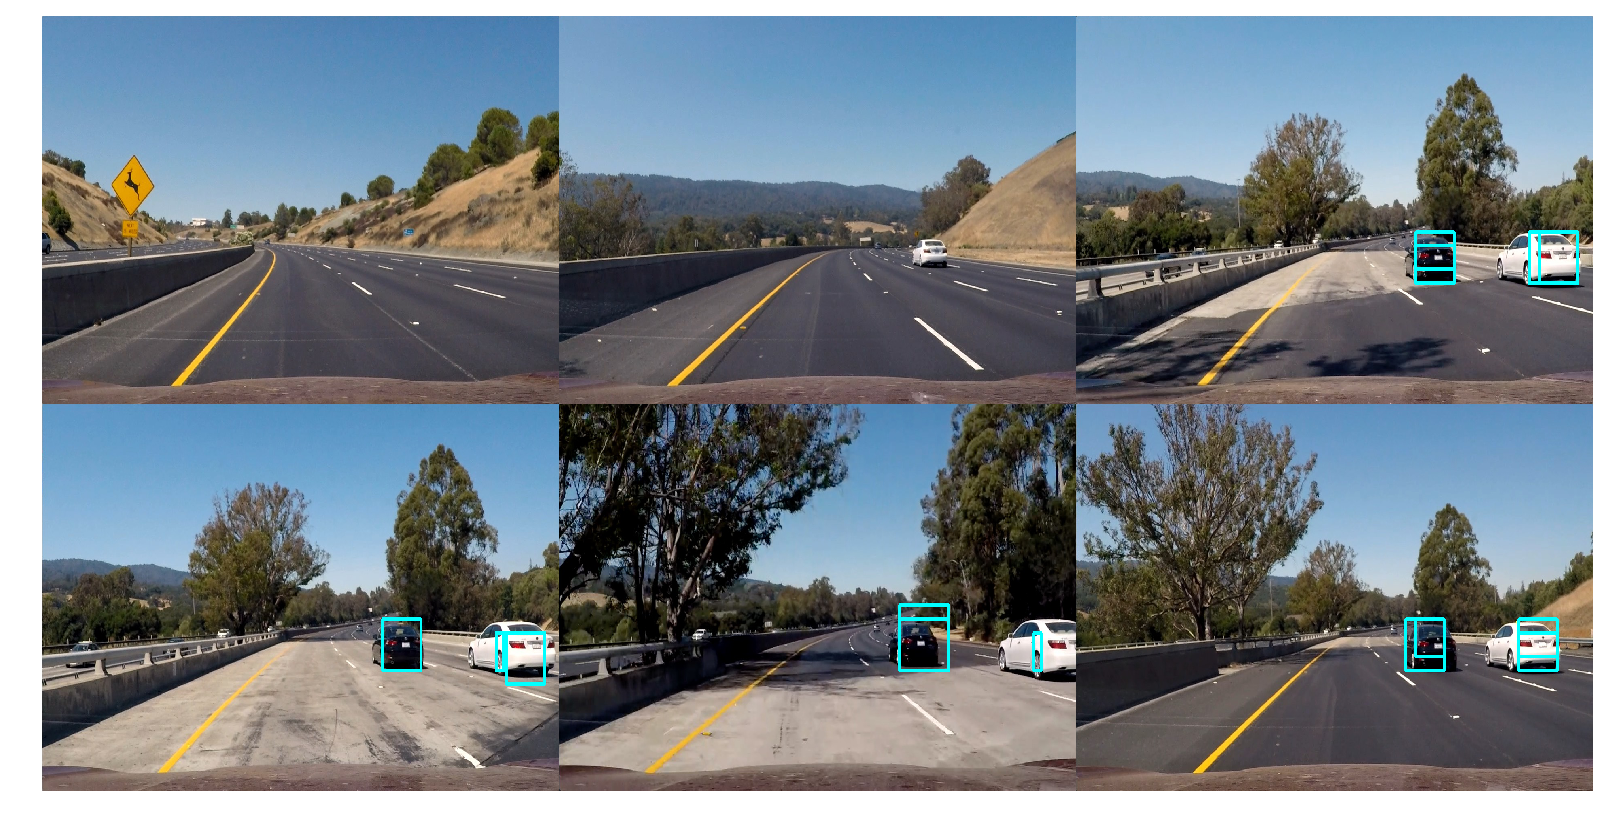

In [16]:
mosaic(test_images_detected, 10, 20, 3).show()

**Figure 4** Test images. The approach identifies vehicles reasonably well, but is certainly not perfect. Searches at additional scales (there is a reduction here due to computational burden and time constraints) would certainly improve the definition of bounding boxes. The vehicle in image 2 is on the edge of the detection area, and it appears to be excluded for this reason. 

### Application to Video 

The pipeline above is easily applied to each frame of a video stream. 

In [17]:
video1_output = 'test_video_final.mp4'
detector = VehicleDetector(model, video=True)

video1 = VideoFileClip("test_video.mp4")
video1_processed = video1.fl_image(detector.detect_vehicles)

%time video1_processed.write_videofile(video1_output, audio=False)

[MoviePy] >>>> Building video test_video_final.mp4
[MoviePy] Writing video test_video_final.mp4


 97%|█████████▋| 38/39 [06:31<00:11, 11.03s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_final.mp4 

CPU times: user 7min 22s, sys: 6.72 s, total: 7min 28s
Wall time: 6min 40s


In [18]:
video0_output = 'project_video_final.mp4'
detector = VehicleDetector(model)

video0 = VideoFileClip("project_video.mp4")
video0_processed = video0.fl_image(detector.detect_vehicles)

%time video0_processed.write_videofile(video0_output, audio=False)

[MoviePy] >>>> Building video project_video_final.mp4
[MoviePy] Writing video project_video_final.mp4


100%|█████████▉| 1260/1261 [4:13:41<00:12, 12.53s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_final.mp4 

CPU times: user 3h 57min 4s, sys: 5min 48s, total: 4h 2min 52s
Wall time: 4h 13min 46s


## Discussion and Concluding Thoughts 

A first and unavoidable point of discussion is the efficiency of the algorithm. On the hardware used for these experiments, it would not be possible to track vehicles in real time. The performance of the algorithm on superior hardware would likely permit real-time vehicle tracking, but reductions in the complexity of the software are also certainly possible. In particular, the sliding window search applied here is somewhat naive and searches the entire region of interest (ROI) for all window sizes. A simple yet impactful improvement would be refining the search, tailoring search window size to the relative proximity to the vehicle of a given region in the ROI. 

While a support vector machine with a linear kernel was found to perform quite well here (Accuracy in testing of ~ 98%), surely other (nonlinear) machine learning strategies are worthy of investigation. A convolutional neural network may also be suitable to the task, and boost performance, given that such methods are known to perform well on comodity hardware (especially when one or more GPUs are availalble). A nod back to the first point of discussion, this would likely increase the performance of the algorithm to real-time, even on the test system used here. Indeed, training, validation, and testing the SVM-based model is quite time-consuming and somewhat of a hindrance to rapid experimentation on the available hardware.

Moving on, the features used to train the model could be further refined. A number of measures of feature relevance exist which are compatible with decision trees and support vector machines. A 'pruning' method based on such a metric could be applied here to reduce the number of features required to train the model, to a 'minimum subset' required to achieve a given performance goal. This could greatly reduce training and detection time by streamlining the underlying model. 

Finally, in cases where the pipeline is applied to video, it would be opportune to 'smooth' the outpu futher. In the two provided videos, the pipeline performs reasonably well, but it does not always succeed in cleanly defining each vehicle in every single frame.